# Motivation

The goal of this notebook is to provide functions to model conversion rate using Bayesian Beta Binomial and elasticity price curve using Bayesian Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import beta
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [2]:
def plot_beta_pdf(a=1, b=1, color=None, label=None, ax=None, shade=False):
    """ Plot probability density function of a parameterized beta distribution.
    It is assumed that the prior has been added into a and b parameter, respectively.
    
    a -- the number of success
    b -- the number of failure
    """
    
    xs = np.linspace(0, 1, 10000)
    ys = beta.pdf(xs, a, b)
    
    if shade:
        ax.fill_betweenx(ys, xs, alpha=0.2)

    ax.plot(xs, ys, color=color, label=label)

Mean 0.26666666666666666


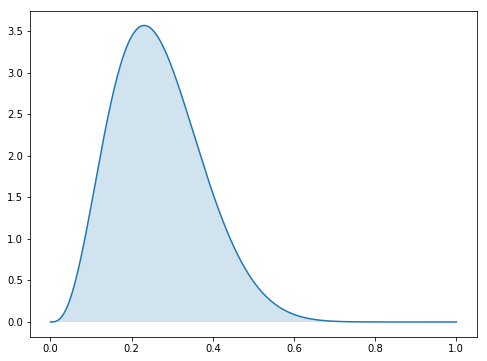

In [3]:
a = 3
b = 10

fig, ax = plt.subplots(figsize=(8, 6))

plot_beta_pdf(a+1, b+1, ax=ax, shade=True)

print('Mean {0}'.format((a+1)/(a+b+2)))

In [4]:
def plot_many_beta_pdf(aa, bb, ax, labels=None, shade=False):
    """ Plot multiple beta distribution probability density function
    
    """
    
    if labels is None:
        labels = ['dist {0}'.format(x) for x in range(len(aa))]

    for a, b, label in zip(aa, bb, labels):
        plot_beta_pdf(a=a, b=b, ax=ax, label=label, shade=shade)

    ax.legend()

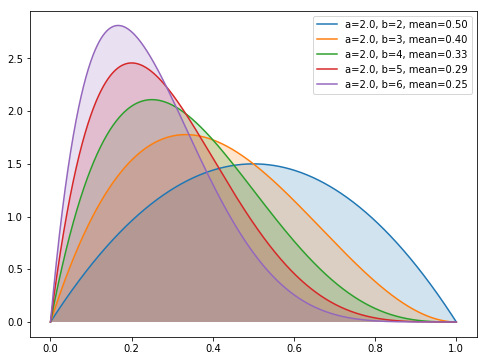

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

aa = np.ones(5) + 1
bb = np.arange(1, 6) + 1
means = [(a/(a+b)) for a, b in zip(aa, bb)]

labels = ['a={0}, b={1}, mean={2:.2f}'.format(a, b, mu) for a, b, mu in zip(aa, bb, means)]

plot_many_beta_pdf(aa=aa, bb=bb, ax=ax, labels=labels, shade=True)

In [6]:
def compare_beta_posterior_sampling(a1, b1, a2, b2):
    """
    Calculate the probability of distribution 1 has bigger conversion rate than distribution 2
    Using monte carlo sampling
    
    a1 -- number of success from distribution 1
    b1 -- number of failure from distribution 2
    a2 -- number of success from distribution 1
    b2 -- number of failure from distribution 2
    """
    
    d1 = np.random.beta(a1, b1, 1000000)
    d2 = np.random.beta(a2, b2, 1000000)
    
    return (d2 > d1).mean()


def compare_beta_posterior_approx(a1, b1, a2, b2):
    """
    Calculate the probability using normal approximation. 
    Learn more here: http://varianceexplained.org/r/bayesian_ab_baseball/
    Should be faster but only accurate when a and b is big
    
    a1 -- number of success from distribution 1
    b1 -- number of failure from distribution 2
    a2 -- number of success from distribution 1
    b2 -- number of failure from distribution 2
    """
    u1 = beta.mean(a1, b1)
    u2 = beta.mean(a2, b2)
    
    var1 = beta.var(a1, b1)
    var2 = beta.var(a2, b2)
    
    return norm.cdf(0, u1-u2, np.sqrt(var1+var2))

probability of dist2 greater than dist1 using sampling is 0.59344
probability of dist2 greater than dist1 using approximation is 0.5916707072103342


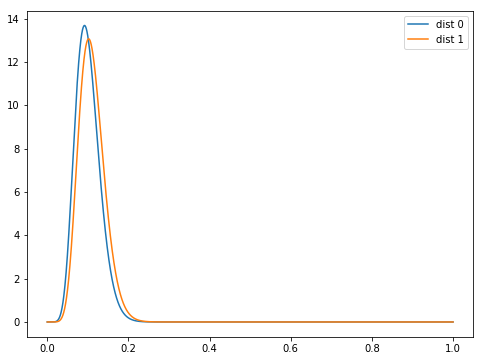

In [7]:
a1 = 10
b1 = 90

a2 = 11
b2 = 89

fig, ax = plt.subplots(figsize=(8, 6))

plot_many_beta_pdf([a1, a2], [b1, b2], ax=ax)

pr1 = compare_beta_posterior_sampling(a1, b1, a2, b2)
pr2 = compare_beta_posterior_approx(a1, b1, a2, b2)

print('probability of dist2 greater than dist1 using sampling is {0}'.format(pr1))
print('probability of dist2 greater than dist1 using approximation is {0}'.format(pr2))

In [8]:
%%time
compare_beta_posterior_sampling(a1, b1, a2, b2)

CPU times: user 249 ms, sys: 10.7 ms, total: 260 ms
Wall time: 222 ms


0.593033

In [9]:
%%time
compare_beta_posterior_approx(a1, b1, a2, b2)

CPU times: user 1.4 ms, sys: 597 µs, total: 2 ms
Wall time: 1.58 ms


0.5916707072103342

In [10]:
# now we are talking about linear regression

In [11]:
def multivariate_normal_posterior(mu, sigma, x, y, noise=0.00001):
 
    variance = noise
    dim = len(x)

    xtx = x.reshape(dim, 1) * x
    V0inv = np.linalg.inv(sigma)
    Vn = np.linalg.inv(V0inv * variance + xtx) * variance
 
    term1 = np.dot(np.dot(Vn, V0inv), mu)
    vnxt = np.dot(Vn, x.reshape(dim, 1))
    term2 = (1/variance) * np.dot(vnxt, y)
    Wn = term1 + term2
 
    return Wn, Vn


def bayes_polynomial_regression(xs, ys, noises, order=1):
  
  # Set prior to be very weak
  mean_prior = np.zeros(order+1)
  sigma_prior = np.eye(order+1)
  
  mean = mean_prior
  sigma = sigma_prior
  
  for x, y, noise in zip(xs, ys, noises):
    point_x = np.array([np.power(x, i) for i in range(1, order+1)[::-1]] + [1])
    point_y = np.array([y])
    mean, sigma = multivariate_normal_posterior(mean, sigma, point_x, point_y, noise)
  
  return mean, sigma


def bayes_linear_regression(xs, ys, noises):
  
  return bayes_polynomial_regression(xs, ys, noises, order=1)


def plot_samples(mean, sigma, x_range, color='#0485d1', ax=None, shade=True, num_sample=10):
  
  x = x_range
  for i in range(1000):
    
    W = np.random.multivariate_normal(mean, sigma)
    y = x*W[0] + W[1]
    ax.plot(x, y, alpha=0.02, color=color)
    
  ax.plot(x, x*mean[0]+mean[1], color='black')

In [12]:
def linear_from_beta(xs, aa, bb):
  
  ys = [np.asscalar(beta.stats(a+1, b+1, moments='m')) for a,b in zip(aa,bb)]
  noises = [np.asscalar(beta.stats(a+1, b+1, moments='v')) for a,b in zip(aa,bb)]
  
  mean, sigma = bayes_linear_regression(xs, ys, noises)
  
  return mean, sigma

In [13]:
def plot_line_from_beta(xs, aa, bb, ax):
  
  mean, sigma = linear_from_beta(xs, aa, bb)
  
  mean, sigma = linear_from_beta(xs, aa, bb)
  plot_samples(mean, sigma, np.arange(np.min(xs)-1, np.max(xs)+1, 0.01), ax=ax)
  ax.plot(xs, aa/(aa+bb), marker='o', linewidth=0, color='salmon')
  
  for a, b, x in zip(aa, bb, xs):
    
    x_range = np.arange(0, 1, 0.001)
    ys = beta.pdf(x_range, a, b)
    ys = ys / (np.max(ys)*2)
    ax.plot(ys+x, x_range)

In [14]:
def plot_normal_pdf(mean, sigma, ax):
  
  x, y = np.mgrid[-3:3:0.01, -3:3:0.01]
  grid = np.zeros(x.shape + (2,))
  grid[:, :, 0] = x
  grid[:, :, 1] = y
  
  rv = multivariate_normal(mean, sigma)

  ctr = ax.contourf(x, y, rv.pdf(grid))

In [15]:
def plot_normal_pdf(mean, sigma, ax):
  
  x, y = np.mgrid[-3:3:0.01, -3:3:0.01]
  grid = np.zeros(x.shape + (2,))
  grid[:, :, 0] = x
  grid[:, :, 1] = y
  
  rv = multivariate_normal(mean, sigma)

  ctr = ax.contourf(x, y, rv.pdf(grid))

In [16]:
def linreg_verbose(xs, ys, noises):
  
  fig, axes = plt.subplots(len(xs)+1, 2, figsize=(10, 20))
  
  # Set prior to be very weak
  mean = np.array([0, 0])
  sigma = np.array([[1, 0], [0, 1]])
  
  ax = axes[0, 0]
  plot_normal_pdf(mean, sigma, ax)
  
  ax = axes[0, 1]
  min_x = np.min(xs)-1
  max_x = np.max(xs)+1
  plot_samples(mean, sigma, np.arange(-max_x, max_x, 0.001), ax=ax)
  
  for x, y, noise, i in zip(xs, ys, noises, range(1, 1+len(xs))):  
    mu, sig = multivariate_normal_posterior(mean, sigma, np.array([x, 1]), np.array([y]), noise)

    mean = mu
    sigma = sig
    ax = axes[i, 0]
    plot_normal_pdf(mean, sigma, ax)
    
    ax = axes[i, 1]
    plot_samples(mean, sigma, np.arange(min_x, max_x, 0.001), ax=ax)
    ax.scatter(xs[:i], ys[:i], marker='o', color='black')
    
  return mean, sigma

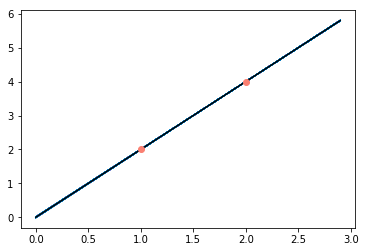

In [17]:
fig, ax = plt.subplots()

xs = [1, 2]
ys = [2, 4]
noises = [0.00001, 0.000001]

mean, sigma = bayes_linear_regression(xs, ys, noises)

plot_samples(mean, sigma, np.arange(0, 3, 0.1), ax=ax)
ax.plot(xs, ys, marker='o', linewidth=0, color='salmon')

display()

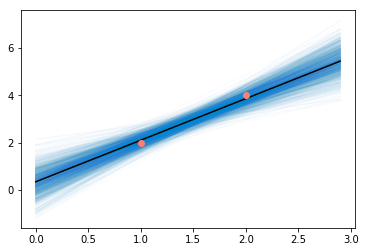

In [18]:
fig, ax = plt.subplots()

xs = [1, 2]
ys = [2, 4]
noises = [0.1, 0.1]

mean, sigma = bayes_linear_regression(xs, ys, noises)

plot_samples(mean, sigma, np.arange(0, 3, 0.1), ax=ax)
ax.plot(xs, ys, marker='o', linewidth=0, color='salmon')

display()

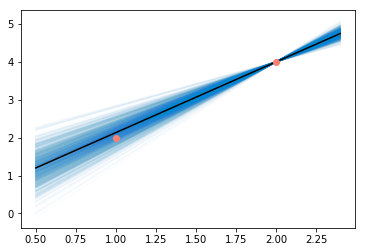

In [19]:
fig, ax = plt.subplots()

xs = [1, 2]
ys = [2, 4]
noises = [0.1, 0.000001]

mean, sigma = bayes_linear_regression(xs, ys, noises)

plot_samples(mean, sigma, np.arange(0.5, 2.5, 0.1), ax=ax)
ax.plot(xs, ys, marker='o', linewidth=0, color='salmon')

display()

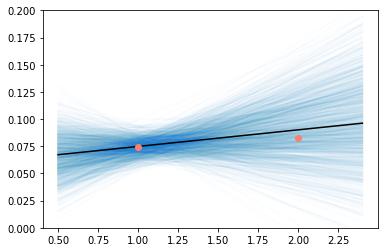

In [20]:
xs = [1, 2]

aa = np.array([80, 9], dtype=float)
bb = np.array([1000, 100], dtype=float)

mean, sigma = linear_from_beta(xs, aa, bb)

fig, ax = plt.subplots()

plot_samples(mean, sigma, np.arange(0.5, 2.5, 0.1), ax=ax)
ax.plot(xs, aa/(aa+bb), marker='o', linewidth=0, color='salmon')
plt.ylim((0, 0.2))

display()

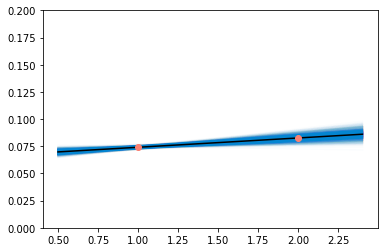

In [21]:
xs = [1, 2]

aa = np.array([8000, 900], dtype=float)
bb = np.array([100000, 10000], dtype=float)

mean, sigma = linear_from_beta(xs, aa, bb)

fig, ax = plt.subplots()

plot_samples(mean, sigma, np.arange(0.5, 2.5, 0.1), ax=ax)
ax.plot(xs, aa/(aa+bb), marker='o', linewidth=0, color='salmon')
plt.ylim((0, 0.2))

display()

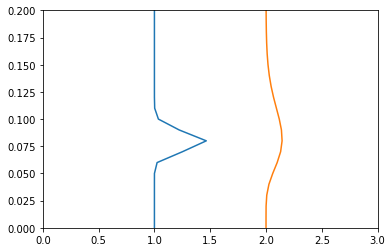

In [22]:
fig, ax = plt.subplots()

xs = np.arange(0, 1, 0.01)
ys = beta.pdf(xs, 80, 1000-80)*0.01
ax.plot(ys+1, xs)

xs = np.arange(0, 1, 0.01)
ys = beta.pdf(xs, 9, 100-9)*0.01
ax.plot(ys+2, xs)

ax.set_xlim(0, 3)
ax.set_ylim(0, 0.2)

display()

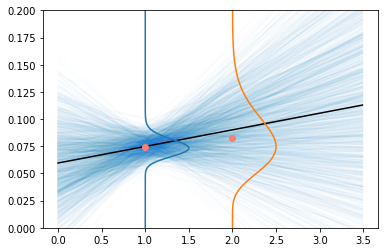

In [23]:
xs = np.array([1, 2])
aa = np.array([80, 9], dtype=float)
bb = np.array([1000, 100], dtype=float)

fig, ax = plt.subplots()

mean, sigma = linear_from_beta(xs, aa, bb)
plot_samples(mean, sigma, np.arange(0, 3.5, 0.01), ax=ax)
ax.plot(xs, aa/(aa+bb), marker='o', linewidth=0, color='salmon')

xs = np.arange(0, 1, 0.001)
ys = beta.pdf(xs, aa[0], bb[0])
ys = ys / (np.max(ys)*2)
ax.plot(ys+1, xs)

xs = np.arange(0, 1, 0.001)
ys = beta.pdf(xs, aa[1], bb[1])
ys = ys / (np.max(ys)*2)
ax.plot(ys+2, xs)

# ax.set_xlim(0, 3)
ax.set_ylim(0, 0.2)

display()

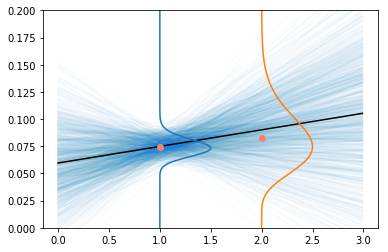

In [24]:
xs = np.array([1, 2])
aa = np.array([80, 9], dtype=float)
bb = np.array([1000, 100], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)

display()

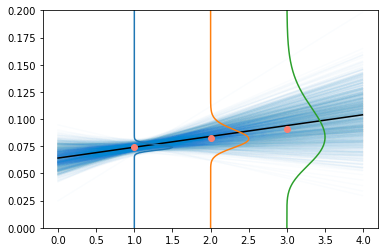

In [25]:
xs = np.array([1, 2, 3])
aa = np.array([800, 90, 10], dtype=float)
bb = np.array([10000, 1000, 100], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)

display()

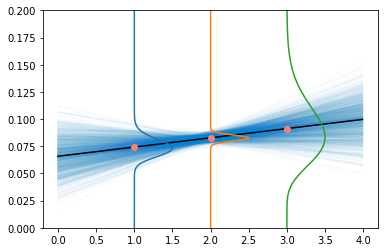

In [26]:
xs = np.array([1, 2, 3])
aa = np.array([80, 900, 10], dtype=float)
bb = np.array([1000, 10000, 100], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)

display()

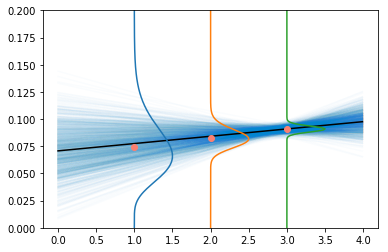

In [27]:
xs = np.array([1, 2, 3])
aa = np.array([8, 90, 1000], dtype=float)
bb = np.array([100, 1000, 10000], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)

display()

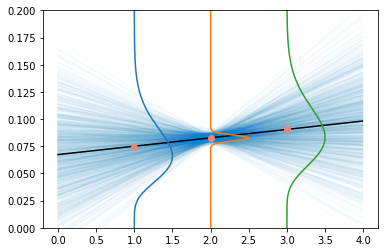

In [28]:
xs = np.array([1, 2, 3])
aa = np.array([8, 900, 10], dtype=float)
bb = np.array([100, 10000, 100], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)

display()

(0, 0.2)

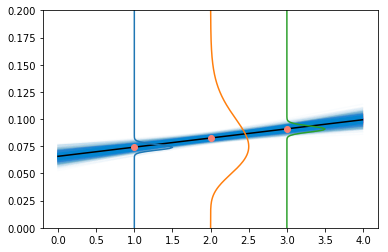

In [29]:
xs = np.array([1, 2, 3])
aa = np.array([800, 9, 1000], dtype=float)
bb = np.array([10000, 100, 10000], dtype=float)

fig, ax = plt.subplots()

plot_line_from_beta(xs, aa, bb, ax)
ax.set_ylim(0, 0.2)


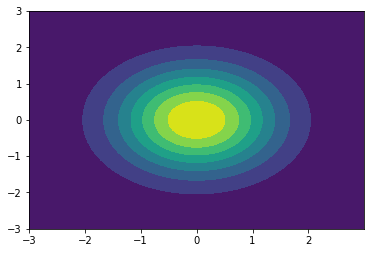

In [30]:
fig, ax = plt.subplots()

plot_normal_pdf([0, 0], [[1, 0], [0, 1]], ax)

(array([0.72812768, 2.32655631]), array([[ 0.00078147, -0.00225974],
        [-0.00225974,  0.0066244 ]]))

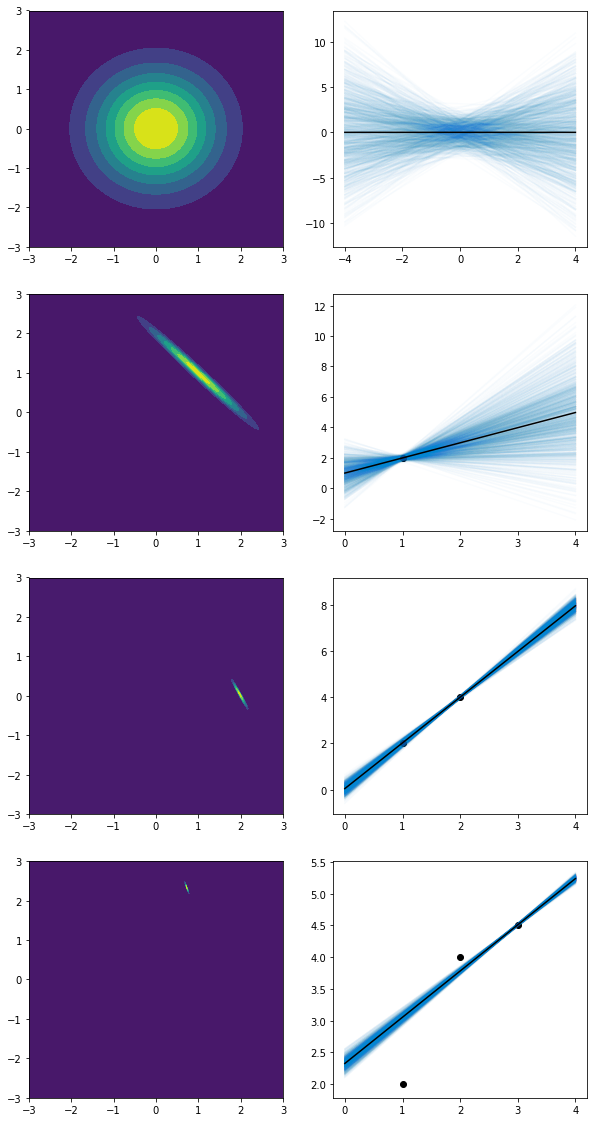

In [31]:
xs = [1, 2, 3]
ys = [2, 4, 4.5]
noises = [0.01, 0.001, 0.0001]

linreg_verbose(xs, ys, noises)

(array([1.27756161, 0.91439689]), array([[ 0.04020752, -0.07782101],
        [-0.07782101,  0.18287938]]))

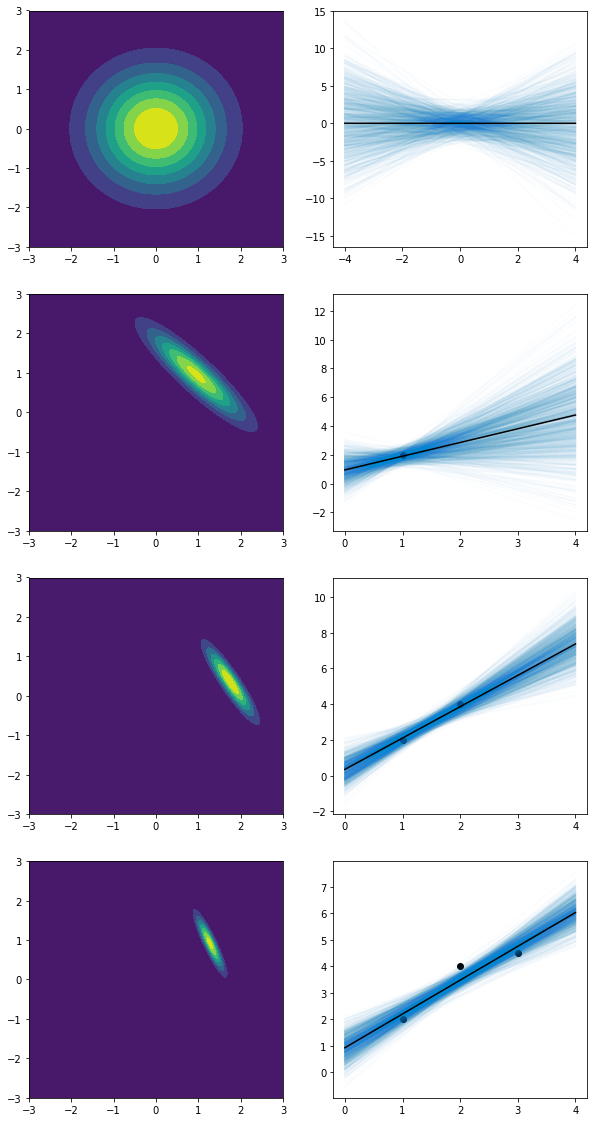

In [32]:
xs = [1, 2, 3]
ys = [2, 4, 4.5]
noises = [0.1, 0.1, 0.1]

linreg_verbose(xs, ys, noises)

In [33]:
# polynomial case

In [34]:
np.random.normal(0, 5, 5)

array([-7.30127755,  2.33569075, -6.23220692,  2.93617378,  1.41946   ])

In [35]:
def generating_function(x):
  
  return 0.1*x*x + 0.3*x + 0.5 + np.random.normal(0, 0.2, 1)[0]

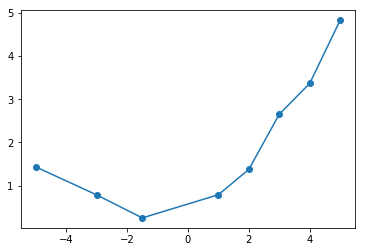

In [36]:
xs = [-5, -3, -1.5, 1, 2, 3, 4, 5]
ys = [generating_function(x) for x in xs]

fig, ax = plt.subplots()

ax.plot(xs, ys, marker='o')

display()

In [37]:
mean, sigma = bayes_polynomial_regression(xs, ys, [0.2]*len(xs), order=2)

In [39]:
order = 2
point_x = np.array([np.power(xs, i) for i in range(1, order+1)[::-1]] + [1])

len(point_x)

3

In [40]:
range(1, order+1)[::-1]

range(2, 0, -1)

In [41]:
np.random.multivariate_normal(mean, sigma, 1)[0][0]

0.09502904587836951

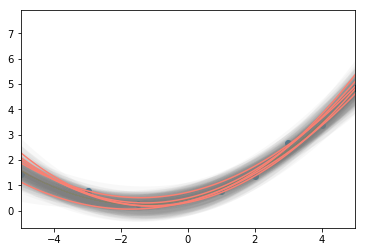

In [42]:
xss = np.linspace(-6, 6, 100)
yss = [mean[0]*x*x + mean[1]*x + mean[2] for x in xss]

fig, ax = plt.subplots()

ax.plot(xs, ys, marker='o', linewidth=0)
ax.plot(xss, yss)

for i in range(100):
  
  W = np.random.multivariate_normal(mean, sigma, 1)[0]
  yss = [W[0]*x*x + W[1]*x + W[2] for x in xss]
  
  ax.plot(xss, yss, alpha=0.05, color='grey', linewidth=8)
  

for i in range(5):
  
  W = np.random.multivariate_normal(mean, sigma, 1)[0]
  yss = [W[0]*x*x + W[1]*x + W[2] for x in xss]
  
  ax.plot(xss, yss, color='salmon')

ax.set_xlim(-5, 5)
display()

In [43]:
# piecewise linear, a good compromise between 

In [44]:
# go full non-parameteric, gaussian process